In [1]:
import math
from scipy import interpolate
import gsw
from xmitgcm import open_mdsdataset
import numpy as np
import xarray as xr
import copy
from matplotlib import pyplot as plt
import matplotlib.colors
%matplotlib inline

In [2]:
rhonil = 999.8
rhoconst = 999.8
tref = 20
sref = 35
sbeta = 7.4e-4
talpha = 2e-4


def get_sigma(temp, lon, lat, lev):
    m = lon.shape[0]
    n = lat.shape[0]
    l = lev.shape[0]

    sigma = linear_rho(35, temp, sref, tref) - 1000

    ds_sigma = xr.DataArray(sigma[:, :, :], coords={'Z': lev, 'YC': lat, 'XC': lon},
                            dims=['Z', 'YC', 'XC'])

    return ds_sigma

def linear_rho(s, t, sref, tref):
    rho = 1000 * (sbeta * (s - sref) - talpha * (t - tref)) + 1025
    return rho

def smooth_2d(data):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    data_new[:, :] = np.nan
    for i in np.arange(1, m, 1):
        for j in np.arange(1, n, 1):
            tmp = data[i-1:i+2, j-1:j+2]
            if math.isnan(data[i, j]) == False:
                data_new[i, j] = np.nanmean(tmp)
    return data_new

In [3]:
def clim_thermo(sigma, temp, u, v, lon, lat, lev, iso, num):

    m = lon.shape[0]
    n = lat.shape[0]
    l = lev.shape[0]

    z = np.arange(10, 1000, 10)

    sigma_z = np.zeros((99, n, m))
    temp_z = np.zeros((99, n, m))
    u_z = np.zeros((99, n, m))
    v_z = np.zeros((99, n, m))

    for k in np.arange(num):
        fun1 = interpolate.interp2d(-lev, lon, sigma[:, k, :].T)
        sigma_z[:, k, :] = fun1(z, lon).T

        fun2 = interpolate.interp2d(-lev, lon, temp[:, k, :].T)
        temp_z[:, k, :] = fun2(z, lon).T

        fun3 = interpolate.interp2d(-lev, lon, u[:, k, :].T)
        u_z[:, k, :] = fun3(z, lon).T

        fun4 = interpolate.interp2d(-lev, lon, v[:, k, :].T)
        v_z[:, k, :] = fun4(z, lon).T

    dep_iso = np.zeros((n, m))
    dep_iso[:, :] = np.nan
    temp_tc = np.zeros((n, m))
    temp_tc[:, :] = np.nan
    u_tc = np.zeros((n, m))
    u_tc[:, :] = np.nan
    v_tc = np.zeros((n, m))
    v_tc[:, :] = np.nan
    nz = np.zeros((n, m))
    
    for i in np.arange(0, m, 1):
        for j in np.arange(0, n, 1):

            den_tmp = sigma_z[:, j, i]
            temp_tmp = temp_z[:, j, i]
            u_tmp = u_z[:, j, i]
            v_tmp = v_z[:, j, i]

            id1 = np.where(den_tmp < iso)

            if np.size(id1) > 0 and np.size(id1) < len(z):

                den1 = den_tmp[id1[0][-1]]
                den2 = den_tmp[id1[0][-1] + 1]

                if den1 < den2:

                    fun = interpolate.interp1d(
                        [den1, den2], [z[id1[0][-1]], z[id1[0][-1] + 1]])
                    dep_iso[j, i] = fun(iso)

                    temp_tc[j, i] = np.nanmean(temp_tmp[:(id1[0][-1])])
                    u_tc[j, i] = np.nanmean(u_tmp[:(id1[0][-1])])
                    v_tc[j, i] = np.nanmean(v_tmp[:(id1[0][-1])])
                    
                    nz[j, i] = id1[0][-1]

    return dep_iso, temp_tc, u_tc, v_tc, nz

- D1

In [4]:
t0 = 280
t1 = 300

data_dir = '/WORK/sio_goc03/pv_flux/coarse_0918/den_jump2/'
ds = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
lev1 = ds.Z
dxc = ds.dxC.values
dyc = ds.dyC.values
raz = ds.rAz.values

temp1 = ds['THETA'][t0:t1, :, :, :]
temp1 = temp1.mean(dim='time')

sigma1 = get_sigma(temp1, lon1, lat1, lev1).values

uu1 = ds['UVEL'][t0:t1, :, :, :]
uu1 = uu1.mean(dim='time').values

vv1 = ds['VVEL'][t0:t1, :, :, :]
vv1 = vv1.mean(dim='time').values

dep_iso1, temp_tc1, u_tc1, v_tc1, nz1 = clim_thermo(sigma1, temp1, uu1, vv1, lon1, lat1, lev1, 26.5, 60)

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

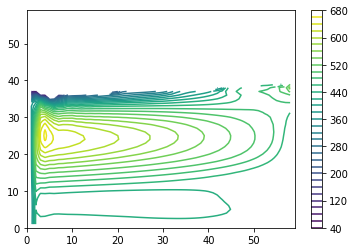

In [5]:
plt.contour(dep_iso1, levels=30)
plt.colorbar()

- D1W1

In [6]:
t0 = 280
t1 = 300

data_dir = '/WORK/sio_goc03/pv_flux/coarse_0918/ex1/'
ds = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
lev1 = ds.Z
dxc = ds.dxC.values
dyc = ds.dyC.values
raz = ds.rAz.values

temp1 = ds['THETA'][t0:t1, :, :, :]
temp1 = temp1.mean(dim='time')

sigma1 = get_sigma(temp1, lon1, lat1, lev1).values

uu1 = ds['UVEL'][t0:t1, :, :, :]
uu1 = uu1.mean(dim='time').values

vv1 = ds['VVEL'][t0:t1, :, :, :]
vv1 = vv1.mean(dim='time').values

dep_iso2, temp_tc2, u_tc2, v_tc2, nz2 = clim_thermo(sigma1, temp1, uu1, vv1, lon1, lat1, lev1, 26.5, 60)

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

- D1W2

In [7]:
t0 = 280
t1 = 300

data_dir = '/WORK/sio_goc03/pv_flux/coarse_0918/ex2/'
ds = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
lev1 = ds.Z
dxc = ds.dxC.values
dyc = ds.dyC.values
raz = ds.rAz.values

temp1 = ds['THETA'][t0:t1, :, :, :]
temp1 = temp1.mean(dim='time')

sigma1 = get_sigma(temp1, lon1, lat1, lev1).values

uu1 = ds['UVEL'][t0:t1, :, :, :]
uu1 = uu1.mean(dim='time').values

vv1 = ds['VVEL'][t0:t1, :, :, :]
vv1 = vv1.mean(dim='time').values

dep_iso3, temp_tc3, u_tc3, v_tc3, nz3 = clim_thermo(sigma1, temp1, uu1, vv1, lon1, lat1, lev1, 26.5, 60)

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [8]:
t0 = 30
t1 = 50

data_dir = '/WORK/sio_goc03/pv_flux/fine_0918/den_jump2/'
ds = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
lev1 = ds.Z
dxc = ds.dxC.values
dyc = ds.dyC.values
raz = ds.rAz.values

temp1 = ds['THETA'][t0:t1, :, :, :]
temp1 = temp1.mean(dim='time')

sigma1 = get_sigma(temp1, lon1, lat1, lev1).values

uu1 = ds['UVEL'][t0:t1, :, :, :]
uu1 = uu1.mean(dim='time').values

vv1 = ds['VVEL'][t0:t1, :, :, :]
vv1 = vv1.mean(dim='time').values

dep_iso4, temp_tc4, u_tc4, v_tc4, nz4 = clim_thermo(sigma1, temp1.values, uu1, vv1, lon1, lat1, lev1, 26.5, 600)

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [9]:
t0 = 30
t1 = 50

data_dir = '/WORK/sio_goc03/pv_flux/fine_0918/ex1/'
ds = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
lev1 = ds.Z
dxc = ds.dxC.values
dyc = ds.dyC.values
raz = ds.rAz.values

temp1 = ds['THETA'][t0:t1, :, :, :]
temp1 = temp1.mean(dim='time')

sigma1 = get_sigma(temp1, lon1, lat1, lev1).values

uu1 = ds['UVEL'][t0:t1, :, :, :]
uu1 = uu1.mean(dim='time').values

vv1 = ds['VVEL'][t0:t1, :, :, :]
vv1 = vv1.mean(dim='time').values

dep_iso5, temp_tc5, u_tc5, v_tc5, nz5 = clim_thermo(sigma1, temp1.values, uu1, vv1, lon1, lat1, lev1, 26.5, 600)

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [10]:
t0 = 30
t1 = 50

data_dir = '/WORK/sio_goc03/pv_flux/fine_0918/ex2/'
ds = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
lev1 = ds.Z
dxc = ds.dxC.values
dyc = ds.dyC.values
raz = ds.rAz.values

temp1 = ds['THETA'][t0:t1, :, :, :]
temp1 = temp1.mean(dim='time')

sigma1 = get_sigma(temp1, lon1, lat1, lev1).values

uu1 = ds['UVEL'][t0:t1, :, :, :]
uu1 = uu1.mean(dim='time').values

vv1 = ds['VVEL'][t0:t1, :, :, :]
vv1 = vv1.mean(dim='time').values

dep_iso6, temp_tc6, u_tc6, v_tc6, nz6 = clim_thermo(sigma1, temp1.values, uu1, vv1, lon1, lat1, lev1, 26.5, 600)

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [11]:
data_dir = '/WORK/sio_goc03/pv_flux/coarse_0918/den_jump2/'
fn = data_dir + 'taux_real_ex1.bin'
data1 = np.fromfile(fn, dtype='>f8')
taux1 = np.reshape(data1, (60, 60))

he = np.zeros((60, 60))
he[:, :] = 450

data_dir = '/WORK/sio_goc03/pv_flux/coarse_0918/den_jump2/'
ds = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
n1 = len(lon1)
m1 = len(lat1)
ln1, lt1 = np.meshgrid(lon1, lat1)
f1 = gsw.f(lt1)
beta1 = np.zeros((n1, m1))
dyc1 = ds.dyC
beta1[:-1, :] = np.diff(f1, axis=0) / dyc1[1:, :]

windy = np.zeros((n1, m1))
windy[:-1, :] = np.diff((taux1 / f1), axis=0) / dyc1[1:, :]

gg = 0.03
den0 = 1025

dxc = ds.dxC
xx = np.zeros((n1, m1))
for i in np.arange(60):
    for j in np.arange(60):
        xx[j, i] = np.sum(dxc[j, i:])
    
hh = np.sqrt(he**2 + 2 * f1**2 * windy / (gg * 1025 * beta1) * xx)

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [12]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 16, 'axes.labelsize' : 16,
      'legend.fontsize' : 16,'legend.handlelength': 2})

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

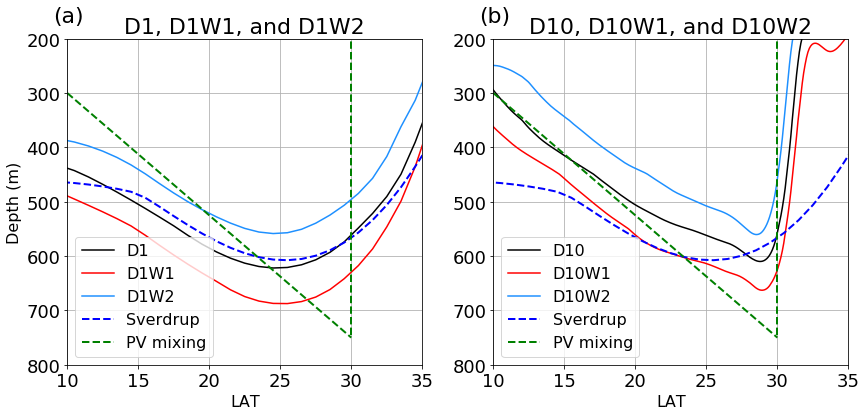

In [13]:
lat1 = np.arange(0.5, 60, 1)
lat2 = np.arange(0.05, 60, 0.1)

fig = plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(lat1, dep_iso1[:, 12], color='k', label='D1')
plt.plot(lat1, dep_iso2[:, 12], color='r', label='D1W1')
plt.plot(lat1, dep_iso3[:, 12], color='dodgerblue', label='D1W2')
plt.plot(lat1, hh[:, 12], color='b', linestyle='--', label='Sverdrup', linewidth=2)
plt.plot([10, 30], [300, 750], color='g', linestyle='--', linewidth=2)
plt.plot([30, 30], [0, 750], color='g', linestyle='--', label='PV mixing', linewidth=2)

plt.ylim(200, 800)
plt.gca().invert_yaxis()
plt.xlim(10, 35)
plt.grid()
plt.title('D1, D1W1, and D1W2', size=22)
plt.legend(loc=3)
plt.xlabel('LAT')
plt.ylabel('Depth (m)')
plt.text(9, 170, '(a)', size=22)

plt.subplot(122)
plt.plot(lat2, dep_iso4[:, 120], color='k', label='D10')
plt.plot(lat2, dep_iso5[:, 120], color='r', label='D10W1')
plt.plot(lat2, dep_iso6[:, 120], color='dodgerblue', label='D10W2')
plt.plot(lat1, hh[:, 12], color='b', linestyle='--', label='Sverdrup', linewidth=2)

plt.plot([10, 30], [300, 750], color='g', linestyle='--', linewidth=2)
plt.plot([30, 30], [0, 750], color='g', linestyle='--', label='PV mixing', linewidth=2)

plt.ylim(200, 800)
plt.gca().invert_yaxis()
plt.xlim(10, 35)
plt.xlabel('LAT')
plt.legend()

plt.grid()
plt.title('D10, D10W1, and D10W2', size=22)
plt.text(9, 170, '(b)', size=22)

plt.savefig('./pics/Figure_10.png', dpi=200, bbox_inches='tight')